# Sarcarsm detection...KEKW

In [1]:
# import nltk
# nltk.download()

In [2]:
import re
import string
import eli5
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from nltk import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

%matplotlib inline
# sns.set()

STOP_WORDS = ENGLISH_STOP_WORDS.union(stopwords.words('english'))

## Exploratory Data Analysis

In [3]:
train_df = pd.read_csv('datasets/sarcasm/train-balanced-sarcasm.csv')
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [4]:
test_df = pd.read_csv('datasets/sarcasm/test-balanced.csv')
test_df.head()

,7x7dx,c07nkao c07nk63,1 0
0,7xtxk,c07pji4 c07ppds,1 0
1,7zh5l,c07twag c07twp2,1 0
2,80nmo,c07y1rj c07xhyn,0 1
3,8139p,c07yhlm c07yoiw,1 0
4,bnmod,c0nnujf c0nofrs,1 0


This test set looks weird... let's work only with train set.

In [5]:
train_df['label'].value_counts()

0    505413
1    505413
Name: label, dtype: int64

Target variable is balanced (as the name of csv file says)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [7]:
train_df.isna().sum()

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

We can remove those 53 rows from `train_df` because they are not a significant amount of data regarding to the total of instances in `train_df`

In [8]:
train_df.dropna(subset=['comment'], axis=0, inplace=True)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train_df['comment'], train_df['label'], test_size=0.2,
                                                    random_state=42)

In [10]:
X_train.head()

329453    Leo breaking the glass and cutting his hand wa...
923237                 I like 11th, it is freaking awesome.
780576             You're a robot, you don't have emotions!
956155    Everyone knows black people don't have jobs so...
474410    Thank you for that reasoned and well argued co...
Name: comment, dtype: object

In [11]:
X_train.to_frame().head()

,comment
329453,Leo breaking the glass and cutting his hand wa...
923237,"I like 11th, it is freaking awesome."
780576,"You're a robot, you don't have emotions!"
956155,Everyone knows black people don't have jobs so...
474410,Thank you for that reasoned and well argued co...


In [12]:
# Usually, X_train and X_test are dataframes, instead of series
X_train = X_train.to_frame()
X_test = X_test.to_frame()

### Data about the data (comments)

We can get some information about the comments e.g., number of words, unique words, stopwords, punctuation, average length of words.

**Note:** The "new data" will be added to both train and test set.

In [13]:
def get_data_about_data(df):
    """
    """
    # Calculate the number of words for each row
    df['num_words'] = df['comment'].apply(lambda row: len(str(row).split()))
    # Calculate the number of unique words for each row
    df['num_unique_words'] = df['comment'].apply(lambda row: len(set(str(row).split())))
    # Calculate the number of stopwords for each row
    df['num_stopwords'] = df['comment'].apply(lambda row: len([word for word in str(row).lower().split() if word in STOP_WORDS]))
    # Calculate the number of punctuations for each row
    df['num_punctuations'] = df['comment'].apply(lambda row: len([word for word in str(row).lower().split() if word in string.punctuation]))
    # Calculate the average words length for each row
    df['avg_words_length'] = df['comment'].apply(lambda row: np.mean([len(word) for word in str(row).split()]))

#     # Apply is a little bit faster (slightly) than list comprehension. Almost 0.10 s the difference
#     df['num_words'] = [len(str(row).split()) for row in df.comment]
#     df['num_unique_words'] = [len(set(str(row).split())) for row in df.comment]
#     df['num_stopwords'] = [len([word for word in str(row).lower().split() if word in STOP_WORDS]) for row in df.comment]

In [14]:
%%time
temp_train = pd.concat([X_train, y_train], axis=1)
get_data_about_data(temp_train)

CPU times: user 28.5 s, sys: 73.9 ms, total: 28.6 s
Wall time: 28.6 s


In [15]:
temp_train.describe()

,label,num_words,num_unique_words,num_stopwords,num_punctuations,avg_words_length
count,808618.00000,808618.000000,808618.000000,808618.000000,808618.000000,808618.000000
mean,0.49975,10.461944,9.944565,5.122833,0.022385,4.772567
std,0.50000,10.552953,7.070347,4.691944,0.310701,17.314899
min,0.00000,1.000000,1.000000,0.000000,0.000000,1.000000
25%,0.00000,5.000000,5.000000,2.000000,0.000000,4.000000
50%,0.00000,9.000000,8.000000,4.000000,0.000000,4.500000
75%,1.00000,14.000000,13.000000,7.000000,0.000000,5.086957
max,1.00000,2222.000000,615.000000,403.000000,130.000000,10000.000000


Look at the max value of each feature, specifically `num_words` and `avg_words_length`, it looks like there are many outliers in the data.

Note: In a normal distribution, 99.7% of data are in range of -3 std to 3 std.

In [16]:
temp_train[temp_train['num_words'] > 150]

,comment,label,num_words,num_unique_words,num_stopwords,num_punctuations,avg_words_length
267034,[I'M DAJUAN ENERGY MCDANIEL I'M DAJUAN ENERGY ...,0,152,10,0,0,5.868421
145053,This is a pretty good theory on the first and ...,0,172,126,96,4,4.470930
115806,Everyone can misread people from time to time....,0,174,116,95,0,4.591954
266603,Comcast Comcast Comcast Comcast Comcast Comcas...,0,188,3,0,0,7.000000
411840,#[MONEY MONEY MONEY MONEY MONEY MONEY MONEY MO...,0,1664,3,0,0,5.008413
297571,2.1 v0.60.133913 (20 Jul 2016) 2.2 v0.60.13386...,1,215,128,1,0,5.344186
177068,"You've got nothing, got nothing, got nothing, ...",0,381,6,3,0,5.488189
437212,Donald Trump Donald Trump Donald Trump Donald ...,0,800,2,0,0,5.500000
583895,lm ayy lm ayy lm ayy lm ayy lm ayy lm ayy lm a...,0,841,3,0,0,2.996433
127231,I am not sure if you are interested in going t...,0,292,42,187,0,3.294521


Too spam :c. We need to remove these "outliers" comments.

One way to remove spam comments is looking at the `num_words` and `num_unique_words`. If `num_words` is pretty higher than `num_unique_words`, then the comment probably is spam. Keep in mind this idea works better with outlier comments.

Note: Not all comments with more than 100 number of words are spam, however, they are outliers and make a tail in the distribution.

In [17]:
temp_train.loc[115806]['comment'] # Not spam comment

"Everyone can misread people from time to time...I would disagree that 99 percent of people are better than her... From just this cast I would say Nat, Paul, Corey, Paulie, Bridge, Day.... come to mind as people that can read people and situations better than her (They have other flaws in their game though which hurt them) Nicole has made A LOT of misreads, and from what I have seen, she makes these mental images of people or situations in her head, and then doesn't allow for new information to change these perceptions...SOme people just take longer to develop that skill in life... that's Nicole it's just something she doesn't do well at the current time... SHe didn't do it well in BB16 and hasn't improved on it IMO... She has improved strategy, throwing comps, etc...other facets of the game... but this she hasnt I agree a lot of other people do this as well.... I'm just saying it's what separates an OK player from a good player... Nicole is an OK player IMO."

In [18]:
temp_train.loc[739109]['comment'] # Also, not spam comment

"Yeah sure, runes are extra stats you get before the game even starts and your rune page is divided in 4 sections the first section is called 'marks' where you basically want to choose damage runes of any kind for instance attack damage, penetration, attack speed and such the second is called 'seals' this is basically a toss up between health and amor but mostly everyone just runs armor, the third is 'glyphs' here you choose between ability power magic resist or cooldowns mostly and the last section are 'quintessences' these are super runes wich are basically 3x better than normal runes and you can choose whatever you want here, you have room for 9 of each normal rune except for quints you only get 3 slots, this makes having a lot of rune pages vital because if you only have a couple of pages you wont enter every matchup the best way possible"

In [19]:
temp_train.loc[297571]['comment'] # Spam comment

'2.1 v0.60.133913 (20 Jul 2016) 2.2 v0.60.133861 (15 Jul 2016) 2.3 v0.60.133811 (13 Jul 2016) 2.4 v0.60.133617 (22 Jun 2016) 2.5 v0.60.133516 (15 Jun 2016) 2.6 v0.59.131908 (04 Mar 2016) 2.7 v0.59.131642 (17 Feb 2016) 2.8 v0.59.131498 (10 Feb 2016) 2.9 v0.59.131440 (04 Feb 2016) 2.10 v0.59.131121 (13 Jan 2016) 2.11 v0.59.131009 (21 Dec 2015) 2.12 v0.59.130861 (10 Dec 2015) 2.13 v0.58.129488 (14 Sep 2015) 2.14 v0.58.129143 (26 Aug 2015) 2.15 v0.57.128177 (10 Jun 2015) 2.16 v0.55.127157 (1 Apr 2015) 2.17 v0.54.126646 (4 Mar 2015) 2.18 v0.54.126645 (25 Feb 2015) 2.19 v0.53.126384 (4 Feb 2015) 2.20 v0.52.126010 (19 Dec 2014) 2.21 v0.51.125720 (03 Dec 2014) 2.22 v0.50.125369 (05 Nov 2014) 2.23 v0.49.124972 (24 Sep 2014) 2.24 v0.49.124971 (17 Sep 2014) 2.25 v0.48.124737 (13 Aug 2014) 2.26 v0.47.124641 (30 Jul 2014) 2.27 v0.46.124490 (02 Jul 2014) 2.28 v0.45.124426 (18 Jun 2014) 2.29 v0.44.123802 (28 May 2014) 2.30 v0.44.123800 (23 Apr 2014) 2.31 v0.43.116251 (22 Mar 2014) 2.32 v0.42.116181 (

In [20]:
outlier_num_words = 50 # almost 5 std
spam_comments = temp_train.loc[(temp_train['num_words'] > outlier_num_words) & ((temp_train['num_words']/2) > temp_train['num_unique_words'])]
temp_train.drop(spam_comments.index, inplace=True)

In [21]:
temp_train.describe()

,label,num_words,num_unique_words,num_stopwords,num_punctuations,avg_words_length
count,808547.000000,808547.000000,808547.00000,808547.000000,808547.000000,808547.000000
mean,0.499782,10.423174,9.94338,5.120822,0.021972,4.772539
std,0.500000,7.986773,7.03565,4.641666,0.277521,17.315637
min,0.000000,1.000000,1.00000,0.000000,0.000000,1.000000
25%,0.000000,5.000000,5.00000,2.000000,0.000000,4.000000
50%,0.000000,9.000000,8.00000,4.000000,0.000000,4.500000
75%,1.000000,14.000000,13.00000,7.000000,0.000000,5.086957
max,1.000000,276.000000,151.00000,122.000000,130.000000,10000.000000


In [22]:
temp_train[temp_train['num_punctuations'] == 130]

,comment,label,num_words,num_unique_words,num_stopwords,num_punctuations,avg_words_length
767161,Messi + Neymar + Iniesta + Xavi + Villa + Piqu...,1,276,144,2,130,3.778986


In [23]:
temp_train[temp_train['avg_words_length'] == 10000]

,comment,label,num_words,num_unique_words,num_stopwords,num_punctuations,avg_words_length
600882,YOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...,0,1,1,0,0,10000.0


In [24]:
temp_train.drop([767161, 600882], inplace=True)

For purposes of visualize the data, let's remove any outlier comments which contains more than 50 `num_words`

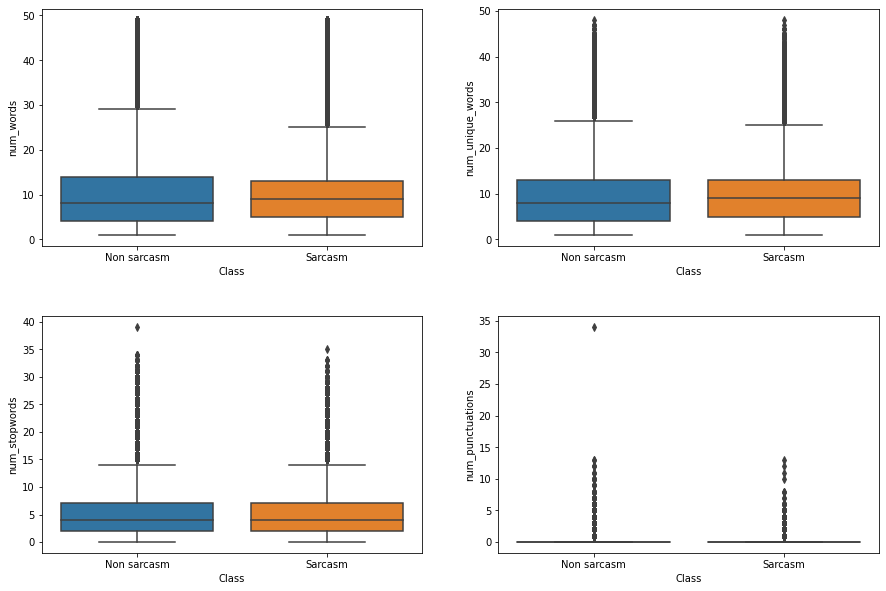

In [25]:
removed_train = temp_train.loc[(temp_train['num_words'] < outlier_num_words)]
columns_to_show = ['num_words', 'num_unique_words', 'num_stopwords', 'num_punctuations', 'avg_words_length']

# Plotting mean
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
ax_flat = axes.reshape((-1,))
for i, column in enumerate(columns_to_show[:-1]):
    sns.boxplot(x='label', y=column, data=removed_train, ax=ax_flat[i], )
    ax_flat[i].set(xlabel="Class")
    ax_flat[i].set_xticks(removed_train['label'].unique()) # Por si acaso
    ax_flat[i].set_xticklabels(['Non sarcasm', 'Sarcasm'])
    
plt.subplots_adjust(hspace=0.3, wspace=0.2)

It seems that sarcartic and non sarcastic comments have similar distributions about number of words, unique words and stopwords.

In [26]:
temp_train['num_punctuations'].value_counts()

0     795397
1      11110
2       1229
3        334
4        171
5         94
6         68
7         36
8         28
10        16
9         15
13         9
11         9
12         7
20         4
15         3
14         3
22         3
21         2
16         2
37         1
18         1
17         1
19         1
34         1
Name: num_punctuations, dtype: int64

That's why `num_punctuation` boxplot looks like so.

To get better insights about the "new data", let's visualize it not from each comment but from both classes of comments, sarcasm and non sarcasm (target variable values).

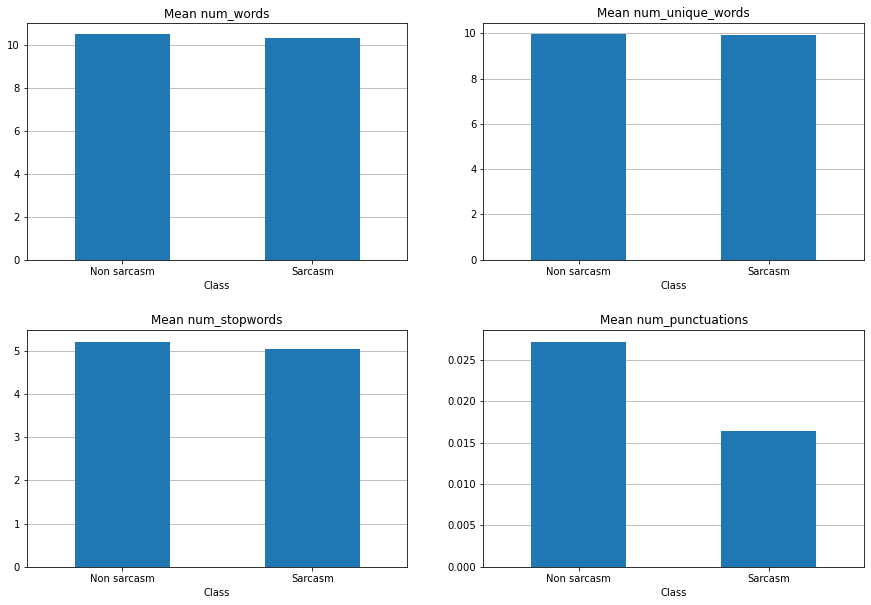

In [27]:
# Plotting mean
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
ax_flat = axes.reshape((-1,))
for i, column in enumerate(columns_to_show[:-1]):
    ax_flat[i].set_title("Mean " + column)
    temp_train.groupby(['label'])[column].mean().plot.bar(ax=ax_flat[i])
    ax_flat[i].set(xlabel="Class")
    ax_flat[i].tick_params(axis='x', labelrotation = 0)
    ax_flat[i].set_xticklabels(['Non sarcasm', 'Sarcasm'])
    ax_flat[i].grid(axis='y') 
    ax_flat[i].set_axisbelow(True)

plt.subplots_adjust(hspace=0.3, wspace=0.2)

Before continuing the analysis of the comments, we need to reasign `X_train` and `y_train` because we removed the outliers and it's better not to work with them in future processes.

In [28]:
X_train_new = temp_train['comment']
y_train_new = temp_train['label']

X_train_new = X_train_new.to_frame()

### Vocabulary of most common words

In order to get the vocabulary of all comments in the train data, we need to keep in mind the following tasks (in general):
* Create a string that contains all coments
* Split that string into words
* Remove unwanted "words" (i.e., stop words and punctuation)
* Apply stemming or lemmatization

Those tasks don't necessarily have to be done in the order that were mentioned.

**Note**: This is a basic process, so it can be improved by adding other considerations (e.g., encoding/decoding unicode characters)



Sauces (to me):
* https://towardsdatascience.com/from-dataframe-to-n-grams-e34e29df3460
* https://machinelearningmastery.com/clean-text-machine-learning-python/
* https://medium.com/@datamonsters/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908
* https://www.nltk.org/book/ch03.html

In [29]:
def serie_to_string(serie):
    """
    Concatenate each row of a serie in one string.
    
    Return a string which contains all column values of a given serie.
    """
    return ' '.join(serie.to_list())

def clean_string(text):
    """
    Returns a list of words as result of splitting a given string in tokens and removing those which are
    "stop words".
    """
    # Convert text to lowercase, split it into tokens. # The punctuation was removed by regex "[^\w\s]"
    tokens = re.sub(r'[^\w\s]', ' ', text.lower()).split()
    # Remove unwanted tokens/words (stopwords)
    words = [token for token in tokens if not token in STOP_WORDS]
    return words

def create_ngrams(words, n):
    """
    Returns a serie whose indexes are ngrams and its values are the amount of occurrences of each ngram.
    """
    return pd.Series(ngrams(words, n)).value_counts()

In [30]:
# Extracting sarcastic and non-sarcastic comments
comments_0 = X_train_new.loc[y_train_new[y_train_new == 0].index, 'comment'] # 0 = non sarcasm
comments_1 = X_train_new.loc[y_train_new[y_train_new == 1].index, 'comment'] # 1 = sarcams

# Convert them to one string (each one)
string_0 = serie_to_string(comments_0)
string_1 = serie_to_string(comments_1)

# Clean each string
cleaned_0 = clean_string(string_0)
cleaned_1 = clean_string(string_1)

# Get unigrams of each cleaned string
unigram_0 = create_ngrams(cleaned_0, 1)
unigram_1 = create_ngrams(cleaned_1, 1)

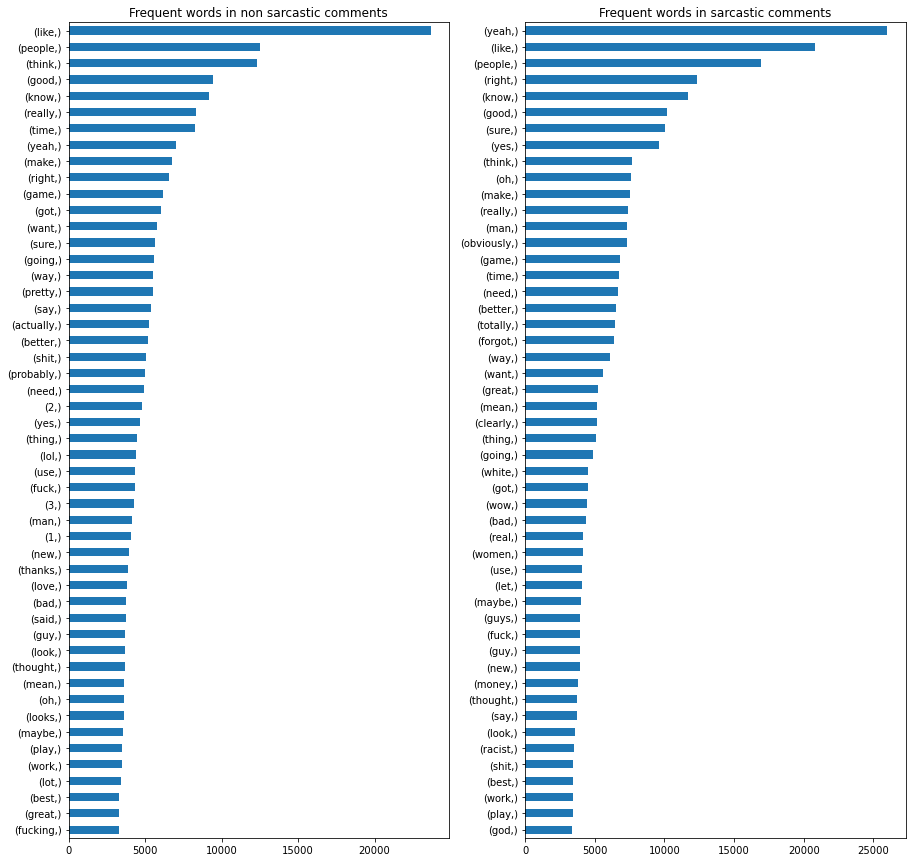

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
unigram_0[:50].sort_values(ascending=True).plot(kind='barh', title='Frequent words in non sarcastic comments', ax=ax1)
unigram_1[:50].sort_values(ascending=True).plot(kind='barh', title='Frequent words in sarcastic comments', ax=ax2)
plt.show();

**Note:** These results come from not applying stemming to the words.

Notice that numbers like 1, 2, or 3 can be found more frequently in non sarcastic comments than sarcastics ones. Maybe this pattern could help machine learning models to make better predictions.

### What about bigrams?

Let's see what are the most common bigrams (two words) from the dataset.

An example of bigram is "yeah sure".

In [32]:
bigram_0 = create_ngrams(cleaned_0, 2)

In [33]:
bigram_1 = create_ngrams(cleaned_1, 2)

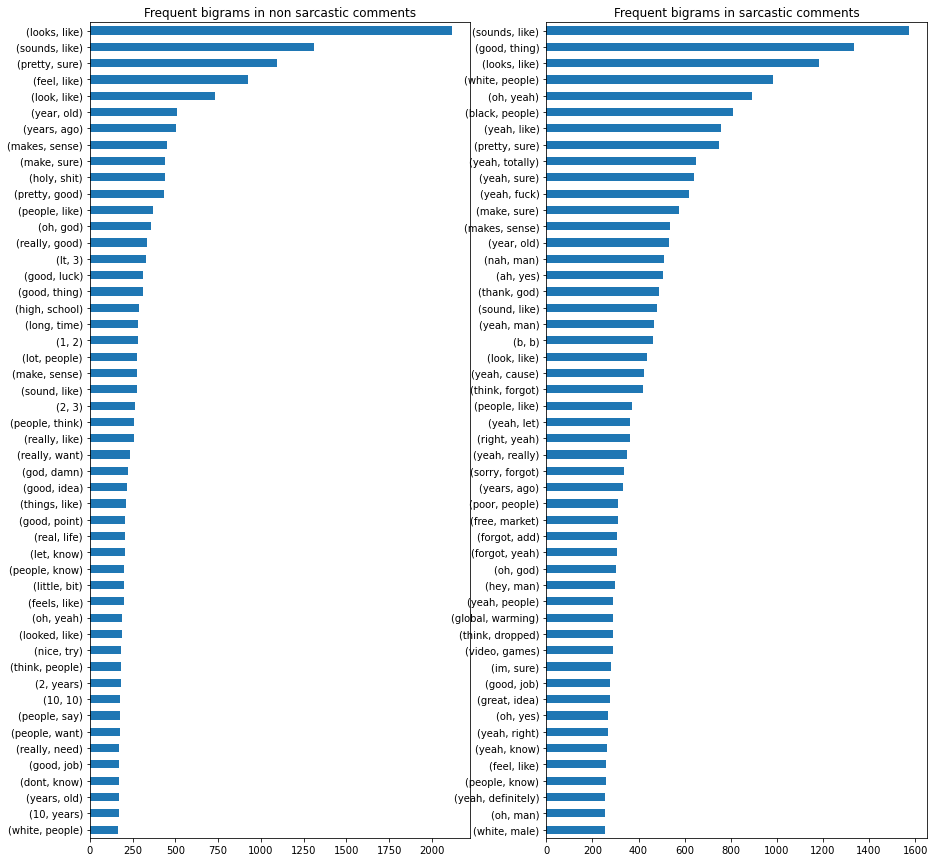

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
bigram_0[:50].sort_values(ascending=True).plot(kind='barh',
                                              title='Frequent bigrams in non sarcastic comments', ax=ax1)
bigram_1[:50].sort_values(ascending=True).plot(kind='barh',
                                              title='Frequent bigrams in sarcastic comments', ax=ax2)
plt.show();

It seems that the word "yeah" is used frequently in many bigrams.

We've done some data analysis through visualization and some statistics. Now, it's time to use another that can help us to get other (or better) insights about the comments. That is machine learning.

## Build a machine learning model

TO start with, we need to extract those features from the dataset that the machine learning model will use to learn. These features are words and to extract them, we'll use a scikit-learn class called `TfidfVectorizer`.

Note: We could use the words we got before, let's see how goes with Tf-Idf method.

In [35]:
%%time
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 2)) # (1, 2) means unigrams and bigrams
tfidf_train = tfidf.fit_transform(X_train['comment']) # Using the train set with spam comments
tfidf_test = tfidf.transform(X_test['comment'])

CPU times: user 28.8 s, sys: 387 ms, total: 29.2 s
Wall time: 29.2 s


Now, we build our machine learning model.

In [36]:
%%time
log_reg = LogisticRegression(solver='sag')
log_reg.fit(tfidf_train, y_train)

CPU times: user 17.6 s, sys: 0 ns, total: 17.6 s
Wall time: 17.7 s


LogisticRegression(solver='sag')

In [37]:
y_pred = log_reg.predict(tfidf_test)
accuracy_score(y_test, y_pred)

0.6846429719769483

Sadge performance :d

It's time to see what are the words (features) which help the model to predict a comment as sarcasm.  We'll use `eli5` module.

In [38]:
eli5.show_weights(log_reg, vec=tfidf, top=(50, 50)) #Top 50 highest abosulute positive and negative weights

Weight?,Feature
+10.408,obviously
+9.661,clearly
+8.974,totally
+6.933,duh
+6.182,yeah
+5.982,dare
+5.960,gee
+5.915,shitlord
+5.766,good thing
+5.628,amirite


Wow! :0

This is a top word lists sorted by weights (importance to the model), so that why this list is not quite simillar than the list of most frequently words. It means that the model `log_reg` found out a pattern (or patterns) in the comments that is not just about frequency of words.

Because this is a binary problem, scikit-learn's `LogisticRegression` uses a single column to show the best features to predict each class. 

In this case, features in green are better to predict class 1 (y=1) but worse to predict class 0 (y=0). On the other hand, features in red are better to predict class 0 but worse to predict class 1.

Source: https://stackoverflow.com/questions/51659523/eli5-show-weights-with-two-labels

`eli5` has also another method called `show_prediction`.

In [39]:
X_test.head()

,comment
665355,this clearly wearing baggy clothing should mea...
773140,"If your last name was Gary, why would your par..."
507645,because everyone's buying
646008,It's all fun and games until they claim to sme...
661080,Clearly not a true American


In [40]:
#X_test.loc[773140]['comment']
# X_test.iloc[1][0]
X_test.values[1][0]

'If your last name was Gary, why would your parents name you Indiana?'

In [41]:
eli5.show_prediction(log_reg, doc=X_test.values[1][0], vec=tfidf)

In [42]:
eli5.show_prediction(log_reg, doc=X_test.loc[646008][0], vec=tfidf)

In [43]:
eli5.show_prediction(log_reg, doc=X_test.iloc[4][0], vec=tfidf)

### Pipeline
Putting all in a pipeline to automate the whole process

In [1]:
import eli5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
%matplotlib inline

train_df = pd.read_csv('datasets/sarcasm/train-balanced-sarcasm.csv')

X_train, X_test, y_train, y_test = train_test_split(train_df['comment'], train_df['label'], test_size=0.2,
                                                    random_state=42)

model_pipe = Pipeline([('tfidf_vec', TfidfVectorizer(stop_words='english', ngram_range=(1, 2))),
                       ('log_reg_model', LogisticRegression(solver='sag'))])

In [2]:
model_pipe.fit(X_train.astype('str'), y_train)
y_pred = model_pipe.predict(X_test.astype('str'))
accuracy_score(y_test, y_pred)

0.6844227021358685

In [3]:
eli5.show_weights(model_pipe, vec=model_pipe[0], top=(10, 10))

Weight?,Feature
+10.558,obviously
+9.572,clearly
+8.936,totally
+6.674,duh
+6.447,shitlord
+6.084,gee
+5.950,yeah
+5.827,dare
+5.683,forgot
+5.650,amirite
